<a class="anchor" id="top"></a>

# Topic Modeling with LDA to Generate Target Risk Topics
Author: Ainesh Pandey

In this notebook, we will perform topic modeling using [LDA (Latent Dirichlet Allocation)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) on the _Lesson(s) Learned_ column of the `lessons_learned.csv` dataframe. The purpose of this analysis is to attempt to organize the different projects into risk topics. Assuming the LDA model produces reasonable topics, we can use the topic classification as ground truth in a modeling objective.

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Helper Functions for Modeling](#step-2) <br>
[Step 2: Prototyping Baseline Solution](#step-3) <br>
[Step 3: Testing Augmented Inputs](#step-4) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# basic data science packages
import pandas as pd
import numpy as np
np.random.seed(5)

# gensim packages for text preprocessing and LDA
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# nltk packages for text preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

# 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import OneSidedSelection

# modeling packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import statistics

# visualization packages
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

### Data
We import `lessons_learned.csv` and keep all of the data. After some exploratory data analysis, we'll choose which features we will keep as inputs.

In [2]:
df_lessons = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv', encoding='cp1252')

display(df_lessons.shape)
df_lessons.head()

(2101, 17)

,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat..."
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,..."
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate..."
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S..."
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M..."


Next, we will import `risk_classifications.csv`, which we created in [GenerateRiskTarget.ipynb](GenerateRiskTarget.ipynb).

In [3]:
df_riskclasses = pd.read_csv('../data/risk_classifications.csv')

display(df_riskclasses.shape)
df_riskclasses.head()

(2086, 2)

,Lesson ID,Risk Class
0,30004,4
1,30101,4
2,29801,4
3,29702,4
4,29103,4


We will combine both dataframes into a master dataframe. We also drop any rows where Risk Class == 3, based on our findings in the previous notebook.

In [4]:
df_master = df_lessons.merge(df_riskclasses, on='Lesson ID', how='inner')
df_master = df_master[df_master['Risk Class'] != 3].reset_index()

display(df_master.shape)
df_master.head()

(2067, 19)

,index,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics,Risk Class
0,0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat...",4
1,1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,...",4
2,2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate...",4
3,3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S...",4
4,4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M...",4


<a class="anchor" id="step-2"></a>

## Helper Functions for Data Prep and Modeling

There are many repetitive steps during data prep and modeling. Here, we will define helper functions to carry out those tasks.

### Data Preparation Helper Functions

#### preprocess()

We start with the `preprocess()` function, which will use the __gensim__ package's `simple_preprocess()` function and perform some additional steps. During the prototyping stage, we can process using the standard parameters for `simple_preprocess()`. However, for the augmented stage, we need to change the standard *max_len* value.

In [5]:
stemmer = PorterStemmer()

def preprocess_prototype(text):
    global stemmer
    result = ''
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result = result + ' ' + stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
    return result.strip()

def preprocess_augmented(text):
    global stemmer
    result = ''
    for token in gensim.utils.simple_preprocess(text, max_len=np.Inf):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result = result + ' ' + stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
    return result.strip()

#### create_pca_representation()

Next, we will write the `create_pca_representation()` function, which will take our preprocessed descriptions, convert them into TF-IDF vectors, and then convert them using PCA into the format needed for further analysis. This function will also return the vectorizers used for both TF-IDF and PCA.

In [6]:
def create_pca_representation(description_col, type):
    if type=='prototype':
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess_prototype,
                                           stop_words = 'english', strip_accents='unicode', lowercase=True)
    elif type=='augmented':
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess_augmented,
                                           stop_words = 'english', strip_accents='unicode', lowercase=True)
    pca_vectorizer = PCA(n_components=100, random_state=5)

    tfidf_matrix = tfidf_vectorizer.fit_transform(description_col)
    tfidf_df     = pd.DataFrame(tfidf_matrix.todense())
    pca_matrix   = pca_vectorizer.fit_transform(tfidf_df)

    return pca_matrix, tfidf_vectorizer, pca_vectorizer

#### split_data()

Next, we will write the `split_data()` function, which will use __imblearn__ package's `OneSidedSelection()` function and __sklearn__ package's `train_test_split()` function to split the data into a training set and a testing set.

In [7]:
def split_data(df):
    X = df.drop(['Lesson ID', 'Risk Class'], axis=1)
    y = df['Risk Class']

    X, y = OneSidedSelection(random_state=5).fit_resample(X, y)
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

### Modeling Helper Functions

#### Create Custom Scorer

Our model tuning will be based on the F1-score metric. However, because our problem is multi-class, we need to specify the _average_ parameter.

In [8]:
scorer = make_scorer(f1_score, average = 'weighted')

#### model_logisticregression_tuned()

The first model we will try to run is a standard `LogisticRegression` model, tuned for the following parameters:
- *solver*: the algorithm to use in the optimization problem
- *penalty*: the norm of the penalty
- *C*: regularization term

In [9]:
def model_logisticregression_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'solver': ['newton-cg', 'lbfgs'],
        'penalty': ['none', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_lm = GridSearchCV(estimator=LogisticRegression(class_weight='balanced', random_state=5),
                        scoring=scorer, param_grid=param_grid, n_jobs=-1, verbose=0).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_lm.best_params_
    best_solver = best_params['solver']
    best_penalty = best_params['penalty']
    best_C = best_params['C']
    print(best_params)

    # create the final LogisticRegression
    best_lm = LogisticRegression(class_weight='balanced', random_state=5,
                                solver=best_solver,
                                penalty=best_penalty,
                                C=best_C).fit(X_train, y_train)
    lm_pred = best_lm.predict(X_test)
    
    # creating a confusion matrix
    lm_cm = confusion_matrix(y_test, lm_pred)

    # track other related model performance metrics
    lm_metrics = classification_report(y_test, lm_pred, digits=3)
    
    # return the model and the confusion matrix
    return best_lm, lm_pred, lm_cm, lm_metrics

#### model_randomforestclassifier_tuned()

The next model we will try to run is a `RandomForestClassifier` model, tuned for the following parameters:
- *n_estimators*: the number of trees in the forest
- *max_features*: the number of features to consider when looking for the best split
- *max_depth*: the maximum depth of the tree
- *criterion*: the function to measure the quality of a split

In [10]:
def model_randomforestclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = { 
        'n_estimators': range(100, 400, 100),
        'max_features': ['auto', 'log2', 0.25, 0.33, 0.5],
        'max_depth' : [None, 5, 8],
        'criterion' : ['gini', 'entropy']
    }

    # get balanced sample weights
    sample = class_weight.compute_sample_weight('balanced', y_train)

    # run the cross-validated grid search to identify the best parameters for the model
    CV_rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train, sample_weight=sample)

    # extract the best parameters, as selected by the grid search
    best_params = CV_rfc.best_params_
    best_n_estimators = best_params['n_estimators']
    best_max_features = best_params['max_features']
    best_max_depth = best_params['max_depth']
    best_criterion = best_params['criterion']
    print(best_params)

    # create the final RandomForestClassifier
    best_rfc = RandomForestClassifier(class_weight='balanced', random_state=5,
                                    max_features=best_max_features,
                                    n_estimators=best_n_estimators,
                                    max_depth=best_max_depth,
                                    criterion=best_criterion).fit(X_train, y_train, sample_weight=sample)
    rfc_pred = best_rfc.predict(X_test)

    # creating a confusion matrix
    rfc_cm = confusion_matrix(y_test, rfc_pred)

    # track other related model performance metrics
    rfc_metrics = classification_report(y_test, rfc_pred, digits=3)

    # return the model and the confusion matrix
    return best_rfc, rfc_pred, rfc_cm, rfc_metrics

#### model_lgbmclassifier_tuned()

The next model we will try to run is a `LGBMClassifier` model, tuned for the following parameters:
- *max_depth*: maximum tree depth for base learners, <=0 means no limit
- *num_leaves*: maximum tree leaves for base learners
- *reg_alpha*: L1 regularization term on weights
- *reg_lambda*: L2 regularization term on weights
- *min_split_gain*: minimum loss reduction required to make a further partition on a leaf node of the tree

In [11]:
def model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'max_depth': [15, 20, -1],
        'num_leaves': [10, 20, 30],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0, 0.5, 1.0],
        'min_split_gain': [0, 0.2, 0.4]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_lgb = GridSearchCV(estimator=LGBMClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_lgb.best_params_
    best_max_depth = best_params['max_depth']
    best_num_leaves = best_params['num_leaves']
    best_reg_alpha = best_params['reg_alpha']
    best_reg_lambda = best_params['reg_lambda']
    best_min_split_gain = best_params['min_split_gain']
    print(best_params)

    # create the final LGBMClassifier
    best_lgb = LGBMClassifier(class_weight='balanced', random_state=5,
                            max_depth=best_max_depth,
                            num_leaves=best_num_leaves,
                            reg_alpha=best_reg_alpha,
                            reg_lambda=best_reg_lambda,
                            min_split_gain=best_min_split_gain).fit(X_train, y_train)
    lgb_pred = best_lgb.predict(X_test)

    # creating a confusion matrix
    lgb_cm = confusion_matrix(y_test, lgb_pred)

    # track other related model performance metrics
    lgb_metrics = classification_report(y_test, lgb_pred, digits=3)

    # return the model and the confusion matrix
    return best_lgb, lgb_pred, lgb_cm, lgb_metrics

#### model_knnclassifier_tuned()

The next model we will try to run is a `KNeighborsClassifier` model, tuned for the following parameters:
- *n_neighbors*: number of neighbors
- *weights*: weight function used in prediction
- *algorithm*: algorithm used to compute the nearest neighbors
- *p*: power parameter for the Minkowski metric (1=L1, 2=L2, 3=L_3 for Minkowski)

In [12]:
def model_knnclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'n_neighbors': [1, 3, 5],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_knn = GridSearchCV(estimator=KNeighborsClassifier(), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_knn.best_params_
    best_n_neighbors = best_params['n_neighbors']
    best_weights = best_params['weights']
    best_algorithm = best_params['algorithm']
    best_p = best_params['p']
    print(best_params)

    # create the final KNeighborsClassifier
    best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors,
                            weights=best_weights,
                            algorithm=best_algorithm,
                            p=best_p).fit(X_train, y_train)
    knn_pred = best_knn.predict(X_test)

    # creating a confusion matrix
    knn_cm = confusion_matrix(y_test, knn_pred)

    # track other related model performance metrics
    knn_metrics = classification_report(y_test, knn_pred, digits=3)

    # return the model and the confusion matrix
    return best_knn, knn_pred, knn_cm, knn_metrics

#### model_gnbclassifier_tuned()

The final model we will try to run is a `GaussianNB` model, tuned for the following parameters:
- *var_smoothing*: portion of the largest variance of all features that is added to variances for calculation stability

In [13]:
from sklearn.utils import class_weight

def model_gnbclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'var_smoothing': np.logspace(0,-9, num=20)
    }

    # get balanced sample weights
    sample = class_weight.compute_sample_weight('balanced', y_train)

    # run the cross-validated grid search to identify the best parameters for the model
    CV_gnb = GridSearchCV(estimator=GaussianNB(), scoring=scorer,
                          param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train, sample_weight=sample)

    # extract the best parameters, as selected by the grid search
    best_params = CV_gnb.best_params_
    best_var_smoothing = best_params['var_smoothing']
    print(best_params)

    # create the final GaussianNB classifier
    best_gnb = GaussianNB(var_smoothing=best_var_smoothing).fit(X_train, y_train, sample_weight=sample)
    gnb_pred = best_gnb.predict(X_test)

    # creating a confusion matrix
    gnb_cm = confusion_matrix(y_test, gnb_pred)

    # track other related model performance metrics
    gnb_metrics = classification_report(y_test, gnb_pred, digits=3)

    # return the model and the confusion matrix
    return best_gnb, gnb_pred, gnb_cm, gnb_metrics

<a class="anchor" id="step-3"></a>

## Prototyping Baseline Solution

The problem at hand is a classification task; we want to use data available about projects before they are officially launched to predict what class of risk they fall under. Therefore, we intend to generate a text-based description of each project, carry out basic NLP transformations to convert the descriptions into tabular data, and utilize several different multi-class classification algorithms to try to accurately predict which class of risk each project is likely to fall under.

### Prep Dataframe for Prototyping

We will create a prototype of the classification model using just the _Title_ and _Abstract_. Depending on the performance of the model, we may augment the inputs with other features as needed.

First, we need to drop all irrelevant columns.

In [14]:
df_prototyping = df_master[['Lesson ID', 'Title', 'Abstract', 'Risk Class']]

display(df_prototyping.shape)
df_prototyping.head()

(2067, 4)

,Lesson ID,Title,Abstract,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,4
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,4
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,4
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,4
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,4


Next, we need to combine the _Title_ and _Abstract_ into one block of text.

In [15]:
if 'Title' in df_prototyping.columns:
    df_prototyping['Description'] = df_prototyping['Title'].astype(str) + ' ' + df_prototyping['Abstract'].astype(str)
    df_prototyping.drop(['Title', 'Abstract'], axis=1, inplace=True)

display(df_prototyping.shape)
df_prototyping.head()

(2067, 3)

,Lesson ID,Risk Class,Description
0,30004,4,Relationship of Government and Contractor Risk...
1,30101,4,Cable Harness Wiring and Connector Anomalies C...
2,29801,4,Best Practices for the Elemental Profiling of ...
3,29702,4,Integration and Dependency Between Different A...
4,29103,4,Copper Tube Pinch Failure While pinching coppe...


We need to do our usual data preprocessing steps and extract a PCA representation of each _Description_ using our `create_pca_representation()` helper function. We will replace the _Description_ column with this PCA representation.

In [16]:
if 'Description' in df_prototyping.columns:
    pca_matrix, tfidf_vectorizer, pca_vectorizer = create_pca_representation(df_prototyping['Description'], 'prototype')
    df_prototyping.drop('Description', axis=1, inplace=True)
    df_prototyping = pd.concat([df_prototyping, pd.DataFrame(pca_matrix)], axis=1)

display(df_prototyping.shape)
df_prototyping.head()

(2067, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,4,-0.033854,0.082005,0.259533,0.067744,0.047458,-0.047642,-0.051692,0.031634,...,0.019679,-0.015403,0.036234,-0.084950,-0.029656,0.033625,0.001141,-0.062345,0.025706,-0.034294
1,30101,4,0.100768,-0.114094,0.037132,-0.092427,0.037966,-0.012349,0.005554,-0.059482,...,-0.045800,0.118993,0.021418,0.100452,-0.092462,-0.006570,0.046110,-0.038476,0.038111,0.053453
2,29801,4,-0.063784,0.006688,-0.007435,-0.019258,-0.015219,-0.060059,0.013481,-0.061282,...,0.043561,-0.020959,-0.001669,0.007417,0.032759,0.021461,-0.037661,-0.032862,0.047159,0.027639
3,29702,4,-0.034003,0.000247,-0.011641,-0.089555,0.108049,0.064706,-0.057105,-0.028622,...,-0.001350,-0.021536,0.085029,0.035786,-0.122584,0.009606,0.091326,-0.005283,-0.045413,-0.009746
4,29103,4,-0.051290,-0.010528,-0.037038,-0.011080,-0.020117,-0.037159,0.022863,-0.037152,...,0.018976,0.082383,-0.059004,-0.073744,-0.074187,0.030126,-0.114796,0.099240,0.010487,0.045370


We now split the data into a training and testing set using the `split_data()` helper function.

In [17]:
X_train, X_test, y_train, y_test = split_data(df_prototyping)

print('Training Output Variable Distribution')
display(y_train.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test.value_counts())


Training Output Variable Distribution


4    989
0    258
2     66
1      7
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


4    425
0    111
2     28
1      3
Name: Risk Class, dtype: int64

### Multi-Class Modeling on Prototype

***
#### Logistic Regression
***

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}


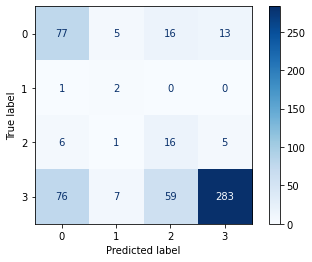

              precision    recall  f1-score   support

           0      0.481     0.694     0.568       111
           1      0.133     0.667     0.222         3
           2      0.176     0.571     0.269        28
           4      0.940     0.666     0.780       425

    accuracy                          0.667       567
   macro avg      0.433     0.649     0.460       567
weighted avg      0.808     0.667     0.710       567



In [18]:
best_lm, lm_pred, lm_cm, lm_metrics = model_logisticregression_tuned(X_train, y_train, X_test, y_test)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=lm_cm).plot(cmap=plt.cm.Blues)
plt.show()
print(lm_metrics)

***
#### Random Forest Classifier
***

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'n_estimators': 200}


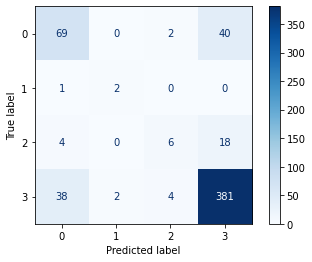

              precision    recall  f1-score   support

           0      0.616     0.622     0.619       111
           1      0.500     0.667     0.571         3
           2      0.500     0.214     0.300        28
           4      0.868     0.896     0.882       425

    accuracy                          0.808       567
   macro avg      0.621     0.600     0.593       567
weighted avg      0.798     0.808     0.800       567



In [19]:
best_rfc, rfc_pred, rfc_cm, rfc_metrics = model_randomforestclassifier_tuned(X_train, y_train, X_test, y_test)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=rfc_cm).plot(cmap=plt.cm.Blues)
plt.show()
print(rfc_metrics)

***
#### Light Gradient Boosted Model Classifier
***

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'max_depth': 15, 'min_split_gain': 0, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5}


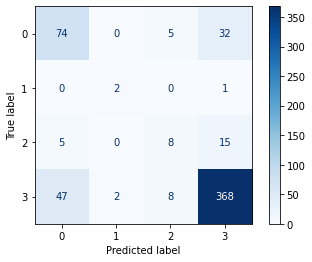

              precision    recall  f1-score   support

           0      0.587     0.667     0.624       111
           1      0.500     0.667     0.571         3
           2      0.381     0.286     0.327        28
           4      0.885     0.866     0.875       425

    accuracy                          0.797       567
   macro avg      0.588     0.621     0.599       567
weighted avg      0.800     0.797     0.797       567



In [20]:
best_lgb, lgb_pred, lgb_cm, lgb_metrics = model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=lgb_cm).plot(cmap=plt.cm.Blues)
plt.show()
print(lgb_metrics)

***
#### K Nearest Neighbors Classifier
***

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'algorithm': 'auto', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}


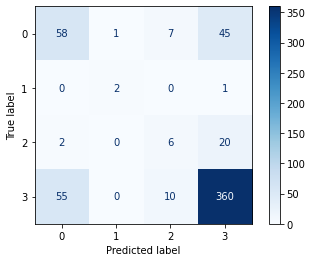

              precision    recall  f1-score   support

           0      0.504     0.523     0.513       111
           1      0.667     0.667     0.667         3
           2      0.261     0.214     0.235        28
           4      0.845     0.847     0.846       425

    accuracy                          0.751       567
   macro avg      0.569     0.563     0.565       567
weighted avg      0.749     0.751     0.750       567



In [21]:
best_knn, knn_pred, knn_cm, knn_metrics = model_knnclassifier_tuned(X_train, y_train, X_test, y_test)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=knn_cm).plot(cmap=plt.cm.Blues)
plt.show()
print(knn_metrics)

***
#### Gaussian Naive Bayes Classifier
***

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'var_smoothing': 0.012742749857031341}


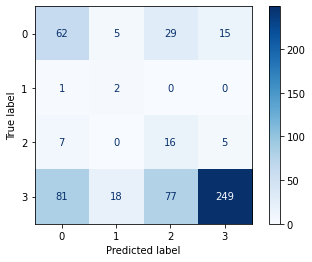

              precision    recall  f1-score   support

           0      0.411     0.559     0.473       111
           1      0.080     0.667     0.143         3
           2      0.131     0.571     0.213        28
           4      0.926     0.586     0.718       425

    accuracy                          0.580       567
   macro avg      0.387     0.596     0.387       567
weighted avg      0.781     0.580     0.642       567



In [22]:
best_gnb, gnb_pred, gnb_cm, gnb_metrics = model_gnbclassifier_tuned(X_train, y_train, X_test, y_test)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=gnb_cm).plot(cmap=plt.cm.Blues)
plt.show()
print(gnb_metrics)

***
#### Custom Ensembles
***

All of our models seem to do well in different areas of the input space. We think we can yield better results by ensembling our different models.

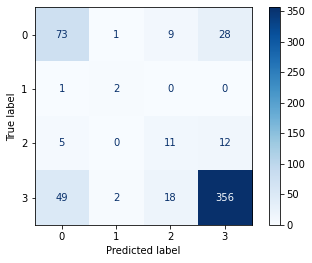

              precision    recall  f1-score   support

           0      0.481     0.694     0.568       111
           1      0.133     0.667     0.222         3
           2      0.176     0.571     0.269        28
           4      0.940     0.666     0.780       425

    accuracy                          0.667       567
   macro avg      0.433     0.649     0.460       567
weighted avg      0.808     0.667     0.710       567



In [26]:
# create a custom ensemble of all of the above methods
df_pred = pd.DataFrame([lm_pred, rfc_pred, lgb_pred, knn_pred, gnb_pred]).T
pred = df_pred.apply(statistics.mode, axis=1)

# creating a confusion matrix
cm = confusion_matrix(y_test, pred)

# track other related model performance metrics
metrics = classification_report(y_test, pred, digits=3)

dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()
print(metrics)

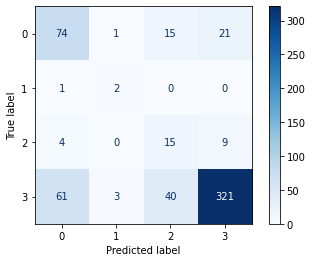

              precision    recall  f1-score   support

           0      0.481     0.694     0.568       111
           1      0.133     0.667     0.222         3
           2      0.176     0.571     0.269        28
           4      0.940     0.666     0.780       425

    accuracy                          0.667       567
   macro avg      0.433     0.649     0.460       567
weighted avg      0.808     0.667     0.710       567



In [27]:
# create a custom ensemble of all of the above methods
df_pred = pd.DataFrame([lm_pred, lgb_pred, knn_pred, gnb_pred]).T
pred = df_pred.apply(statistics.mode, axis=1)

# creating a confusion matrix
cm = confusion_matrix(y_test, pred)

# track other related model performance metrics
metrics = classification_report(y_test, pred, digits=3)

dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()
print(metrics)

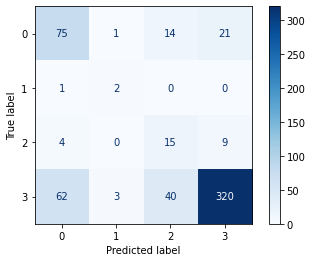

              precision    recall  f1-score   support

           0      0.481     0.694     0.568       111
           1      0.133     0.667     0.222         3
           2      0.176     0.571     0.269        28
           4      0.940     0.666     0.780       425

    accuracy                          0.667       567
   macro avg      0.433     0.649     0.460       567
weighted avg      0.808     0.667     0.710       567



In [28]:
# create a custom ensemble of all of the above methods
df_pred = pd.DataFrame([lm_pred, rfc_pred, knn_pred, gnb_pred]).T
pred = df_pred.apply(statistics.mode, axis=1)

# creating a confusion matrix
cm = confusion_matrix(y_test, pred)

# track other related model performance metrics
metrics = classification_report(y_test, pred, digits=3)

dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()
print(metrics)

<a class="anchor" id="step-4"></a>

## Testing Augmented Inputs

To augment the text-based description, we need to decide which of the available features can add value beyond the _Title_ and _Abstract_ features of the dataframe.

### Prep Dataframe for Prototyping

#### Remove Irrelevant Features

First, we remove any columns containing data unavailable at the beginning of the project.
- _Lesson(s) Learned_ was used to generate the risk classifications. Logically, we cannot use it as an input. Regardless, it is information that comes to light during the course of the project. Therefore, this column will be dropped.
- The other columns that either relate to _Lesson(s) Learned_ or are post-facto include:
    - _Recommendation(s)_
    - _Date Lesson Occurred_
    - _Driving Event_
    - _Evidence_
    - _The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules_
    - _From what phase of the program or project was this lesson learned captured?_
    - _Where (other lessons, presentations, publications, etc.)?_
- _Publish Date_ is also a post-facto column. Furthermore, we don't expect the publication date to actually impact the risk classification.

In [29]:
df_augmented = df_master.copy().drop('index', axis=1)

if 'Lesson(s) Learned' in df_augmented.columns:
    df_augmented.drop(['Lesson(s) Learned', 'Recommendation(s)', 'Date Lesson Occurred', 'Driving Event', 'Evidence',
                       'The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules',
                       'From what phase of the program or project was this lesson learned captured?',
                       'Where (other lessons, presentations, publications, etc.)?', 'Publish Date'], inplace=True, axis=1)

display(df_augmented.shape)
df_augmented.head()

(2067, 9)

,Lesson ID,Title,Abstract,Organization,Project / Program,NASA Mission Directorate(s),Sensitivity,Topics,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,LaRC,Radiation Budget Instrument,"Aeronautics Research, Human Exploration and Op...",Public,"Procurement, Small Business & Industrial Relat...",4
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,NESC,"Space Shuttle Program, Commercial Crewed Space...",Human Exploration and Operations,Public,"Flight Equipment, Ground Operations, Hardware,...",4
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,NESC,All NASA missions using high purity hydrazine ...,"Human Exploration and Operations, Science, Spa...",Public,"Ground Operations, Launch Vehicle, Parts, Mate...",4
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,KSC,Radiological Control Center (RADCC),Human Exploration and Operations,Public,"Engineering Design, Integration and Testing, S...",4
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,KSC,Mass Spectrometer observing lunar operations (...,"Human Exploration and Operations, Space Techno...",Public,"Engineering Design, Integration and Testing, M...",4


#### Categorical Feature Analysis

Next, aside from _Title_ and _Abstract_, we will try to identify which other categorical features (if any) may offer value to the text-based description of the project. We start by checking how many unique values exist for each categorical feature.

In [30]:
df_augmented.iloc[:,3:].nunique()

Organization                    15
Project / Program              200
NASA Mission Directorate(s)     25
Sensitivity                      1
Topics                         435
Risk Class                       4
dtype: int64

- _Organization_ seems to be a straightforward categorical column that provides value and has a manageable number of distinct values. We will keep this in our analysis, but we'll append 'Org' to the front of each value so it does not get removed in our preprocessing steps.
- _Project / Program_ doesn't seem to have a standard format for its values. Furthermore, it has 200 values for a total 2000 different projects. We think including this feature in our analysis would add too many columns for not much value. We will remove this column from analysis and try to see what our initial results look like, before considering including the text from this column in our inputs.
- _NASA Mission Directorate(s)_ seems to be comma-separated values. There may be value in adding them into our analysis. We will need to reformat the inputs to keep track of each mission directoraate separately (e.g. changing 'Aeronautics Research' to 'Directorate_Aeronautics_Research' so our analysis will consider it one term).
- _Sensitivity_ has only one value in the entire column. It is useless and will therefore be removed from our analysis.
- _Topics_ seems to be similar to _NASA Mission Directorate(s)_. We will handle it similarly.

In [31]:
# drop the columns we decided to remove from further analysis
if 'Project / Program' in df_augmented.columns:
    df_augmented.drop(['Project / Program', 'Sensitivity'], axis=1, inplace=True)

# modify contents of columns as described above
def fix_column_values(text, prefix):
    if text == 'nan':
        return ''
        
    text_to_return = ''
    text_split = text.split(',')
    for directorate in text_split:
        text_to_return += prefix + directorate.strip().replace(' ', '_') + ' '
    
    return text_to_return.strip().lower()

if 'Organization' in df_augmented.columns:
    df_augmented['Fixed Organization'] = 'org_' + df_augmented['Organization'].astype(str).apply(str.lower)
    df_augmented['Fixed Directorates'] = df_augmented['NASA Mission Directorate(s)'].astype(str).apply(fix_column_values, prefix='Directorate_')
    df_augmented['Fixed Topics'] = df_augmented['Topics'].astype(str).apply(fix_column_values, prefix='Topic_')
    df_augmented.drop(['Organization', 'NASA Mission Directorate(s)', 'Topics'], axis=1, inplace=True)

display(df_augmented.shape)
df_augmented.head()

(2067, 7)

,Lesson ID,Title,Abstract,Risk Class,Fixed Organization,Fixed Directorates,Fixed Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,4,org_larc,directorate_aeronautics_research directorate_h...,topic_procurement topic_small_business_&_indus...
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,4,org_nesc,directorate_human_exploration_and_operations,topic_flight_equipment topic_ground_operations...
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,4,org_nesc,directorate_human_exploration_and_operations d...,topic_ground_operations topic_launch_vehicle t...
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,4,org_ksc,directorate_human_exploration_and_operations,topic_engineering_design topic_integration_and...
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,4,org_ksc,directorate_human_exploration_and_operations d...,topic_engineering_design topic_integration_and...


Next, we need to combine all of the features into one block of text.

In [32]:
if 'Title' in df_augmented.columns:
    df_augmented['Description'] = df_augmented['Title'].astype(str) + ' ' +\
                                  df_augmented['Abstract'].astype(str) + ' ' +\
                                  df_augmented['Fixed Organization'].astype(str) + ' ' +\
                                  df_augmented['Fixed Directorates'].astype(str) + ' ' +\
                                  df_augmented['Fixed Topics'].astype(str)
    df_augmented.drop(['Title', 'Abstract', 'Fixed Organization', 'Fixed Directorates', 'Fixed Topics'], axis=1, inplace=True)

display(df_augmented.shape)
df_augmented.head()

(2067, 3)

,Lesson ID,Risk Class,Description
0,30004,4,Relationship of Government and Contractor Risk...
1,30101,4,Cable Harness Wiring and Connector Anomalies C...
2,29801,4,Best Practices for the Elemental Profiling of ...
3,29702,4,Integration and Dependency Between Different A...
4,29103,4,Copper Tube Pinch Failure While pinching coppe...


Like we did in the prototyping phase, we will replace the _Description_ column with a PCA representation.

In [33]:
if 'Description' in df_augmented.columns:
    pca_matrix_aug, tfidf_vectorizer_aug, pca_vectorizer_aug = create_pca_representation(df_augmented['Description'], 'prototype')
    df_augmented.drop('Description', axis=1, inplace=True)
    df_augmented = pd.concat([df_augmented, pd.DataFrame(pca_matrix_aug)], axis=1)

display(df_augmented.shape)
df_augmented.head()

(2067, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,4,-0.027343,-0.206953,0.028497,-0.142765,0.116207,0.030320,0.027532,0.006033,...,0.043647,0.004672,0.013972,0.048265,-0.030932,-0.053292,0.050686,-0.030627,-0.003499,-0.006799
1,30101,4,0.081710,-0.044084,-0.049942,-0.057494,-0.130958,-0.081129,-0.017990,-0.015218,...,0.092094,-0.071480,-0.061221,0.004660,-0.027905,0.149701,-0.018921,0.060095,0.077552,-0.003453
2,29801,4,-0.058111,-0.045619,-0.001553,0.029524,-0.039855,-0.023989,0.010627,-0.020775,...,0.082161,-0.045434,0.039285,0.002562,-0.021729,-0.042321,-0.006855,-0.005385,0.003874,0.028212
3,29702,4,-0.029450,-0.044395,-0.036080,0.029603,-0.032345,-0.091593,-0.024204,-0.076670,...,-0.018111,-0.029592,0.021137,0.006203,0.087848,-0.021521,0.028546,-0.036935,0.058806,-0.068857
4,29103,4,-0.055857,0.003103,-0.028929,0.034995,-0.017411,-0.035518,-0.006991,-0.029616,...,0.019773,0.013006,-0.007108,-0.075842,-0.008112,0.059527,0.110251,0.086196,0.010388,0.024514


We now split the data into a training and testing set using the `split_data()` helper function.

In [34]:
X_train_aug, X_test_aug, y_train_aug, y_test_aug = split_data(df_aug)

print('Training Output Variable Distribution')
display(y_train_aug.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test_aug.value_counts())


Training Output Variable Distribution


4    993
0    241
2     62
1      7
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


4    426
0    103
2     27
1      3
Name: Risk Class, dtype: int64

### Multi-Class Modeling on Augmented Inputs

***
#### Logistic Regression
***

In [ ]:
best_lm_aug, lm_pred_aug, lm_cm_aug, lm_metrics_aug = model_logisticregression_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=lm_cm_aug).plot(cmap=plt.cm.Blues)
plt.show()
print(lm_metrics_aug)

***
#### Random Forest Classifier
***

In [35]:
best_rfc_aug, rfc_pred_aug, rfc_cm_aug, rfc_metrics_aug = model_randomforestclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=rfc_cm_aug).plot(cmap=plt.cm.Blues)
plt.show()
print(rfc_metrics_aug)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


KeyboardInterrupt: 

***
#### Light Gradient Booosted Model Classifier
***

In [ ]:
best_lgb, lgb_pred, lgb_cm, lgb_metrics = model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=lgb_cm).plot(cmap=plt.cm.Blues)
plt.show()
print(lgb_metrics)

***
#### K Nearest Neighbors Classifier
***

In [ ]:
best_knn_aug, knn_pred_aug, knn_cm_aug, knn_metrics_aug = model_knnclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=knn_cm_aug).plot(cmap=plt.cm.Blues)
plt.show()
print(knn_metrics_aug)

***
#### Gaussian Naive Bayes Classifier
***

In [ ]:
best_gnb_aug, gnb_pred_aug, gnb_cm_aug, gnb_metrics_aug = model_gnbclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

# display the confusion matrix for the logistic regression model
dist = ConfusionMatrixDisplay(confusion_matrix=gnb_cm_aug).plot(cmap=plt.cm.Blues)
plt.show()
print(gnb_metrics_aug)

***
#### Custom Ensembles
***

In [ ]:
# create a custom ensemble of all of the above methods
df_pred_aug = pd.DataFrame([lm_pred_aug, rfc_pred_aug, lgb_pred_aug, knn_pred_aug, gnb_pred_aug]).T
pred_aug = df_pred_aug.apply(statistics.mode, axis=1)

# creating a confusion matrix
cm = confusion_matrix(y_test, pred_aug)

# track other related model performance metrics
metrics = classification_report(y_test, pred_aug, digits=3)

dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()
print(metrics)